In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import helpers
import networkx as nx
import numpy as np
import os

from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from networkx.algorithms.distance_measures import diameter
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier

## Load Higgs Boson dataset

In [4]:
y, A = helpers.load_data()

## Compute the baseline with SGD classifier 

In [5]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1, random_state=2)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.7444
Final loss: 0.5063267378689544


## Computing with Decentralized SGD

In [7]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 5

params = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.4, regularizer=reg,
                           quantization_method='full', n_machines=8100,
                           communication_method='plain',
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='random', 
                           compute_loss_every=compute_loss_every, tol=1e-10)

### Complete graph

In [15]:
params_complete = params.copy()
params_complete['topology'] = 'complete'
losses_complete = helpers.run_logistic_n_times(A, y, params_complete, 3)

params_complete['initial_lr'] = 0.1
losses_complete_bis = helpers.run_logistic_n_times(A, y, params_complete, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        11s       0.5815    0.7163        
[2/5]      [30/30]        21s       0.5757    0.7208        
[3/5]      [30/30]        32s       0.5728    0.7237        
[4/5]      [30/30]        43s       0.5697    0.7253        
[5/5]      [30/30]        54s       0.5684    0.7256        

Final score: 0.7256
Decentralized optimization, run number 2 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        11s       0.5808    0.7167        
[2/5]      [30/30]        22s       0.5753    0.7210        
[3/5]      [30/30]        34s       0.5722    0.7241        
[4/5]      [30/30]        45s       0.5700    0.7252        
[5/5]      [30/30]        56s       0.5690    0.7260        

Final score: 0.7260
Decentralized optimization, run number 3 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        11s       

### Barbell graph

In [17]:
params_barbell = params.copy()
params_barbell['topology'] = 'barbell'
losses_barbell = helpers.run_logistic_n_times(A, y, params_barbell, 3)

params_barbell['initial_lr'] = 0.1
losses_barbell_bis = helpers.run_logistic_n_times(A, y, params_barbell, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        12s       0.5815    0.7163        
[2/5]      [30/30]        24s       0.5757    0.7208        
[3/5]      [30/30]        36s       0.5728    0.7237        
[4/5]      [30/30]        48s       0.5697    0.7254        
[5/5]      [30/30]        60s       0.5684    0.7256        

Final score: 0.7256
Decentralized optimization, run number 2 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        11s       0.5809    0.7168        
[2/5]      [30/30]        23s       0.5753    0.7210        
[3/5]      [30/30]        36s       0.5722    0.7241        
[4/5]      [30/30]        48s       0.5700    0.7252        
[5/5]      [30/30]        60s       0.5690    0.7260        

Final score: 0.7260
Decentralized optimization, run number 3 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        12s       

### Path graph

In [24]:
params_path = params.copy()
params_path['topology'] = 'path'
losses_path = helpers.run_logistic_n_times(A, y, params_path, 3)

params_path['initial_lr'] = 0.1
losses_path_bis = helpers.run_logistic_n_times(A, y, params_path, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        11s       0.5956    0.7152        
[2/5]      [30/30]        23s       0.5973    0.7192        
[3/5]      [30/30]        34s       0.5958    0.7225        
[4/5]      [30/30]        46s       0.5927    0.7247        
[5/5]      [30/30]        57s       0.5916    0.7266        

Final score: 0.7266
Decentralized optimization, run number 2 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        12s       0.5953    0.7156        
[2/5]      [30/30]        24s       0.5972    0.7197        
[3/5]      [30/30]        35s       0.5952    0.7232        
[4/5]      [30/30]        47s       0.5936    0.7252        
[5/5]      [30/30]        60s       0.5926    0.7263        

Final score: 0.7263
Decentralized optimization, run number 3 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        12s       

### Torus graph

In [25]:
params_torus = params.copy()
params_torus['topology'] = 'torus'
losses_torus = helpers.run_logistic_n_times(A, y, params_torus, 3)

params_torus['initial_lr'] = 0.1
losses_torus_bis = helpers.run_logistic_n_times(A, y, params_torus, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        12s       0.5866    0.7159        
[2/5]      [30/30]        24s       0.5828    0.7204        
[3/5]      [30/30]        36s       0.5800    0.7240        
[4/5]      [30/30]        48s       0.5768    0.7259        
[5/5]      [30/30]        60s       0.5754    0.7270        

Final score: 0.7270
Decentralized optimization, run number 2 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        12s       0.5860    0.7164        
[2/5]      [30/30]        24s       0.5823    0.7210        
[3/5]      [30/30]        37s       0.5792    0.7243        
[4/5]      [30/30]        49s       0.5773    0.7260        
[5/5]      [30/30]        61s       0.5761    0.7268        

Final score: 0.7268
Decentralized optimization, run number 3 

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [30/30]        12s       

## Plots of results

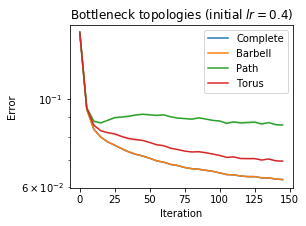

In [41]:
iterations_indices = np.arange(0, losses_complete[0].shape[0] * compute_loss_every, 
                               compute_loss_every)
helpers.plot_losses_with_std([losses_complete, losses_barbell, losses_path, losses_torus],
            iterations_indices, optimum_loss=optimum_loss, 
            labels=['Complete','Barbell', 'Path', 'Torus'], title='Bottleneck topologies (initial $lr=0.4$)', figsize=(4,3))

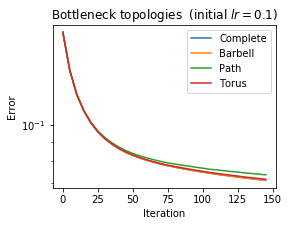

In [39]:
iterations_indices = np.arange(0, losses_complete_bis[0].shape[0] * compute_loss_every, 
                               compute_loss_every)
helpers.plot_losses_with_std(np.stack((losses_complete_bis, losses_barbell_bis, losses_path_bis, losses_torus_bis)),
            iterations_indices, optimum_loss=optimum_loss, 
            labels=['Complete','Barbell', 'Path', 'Torus'], title='Bottleneck topologies  (initial $lr=0.1$)', figsize=(4,3))

## Comparison in terms of  Spectral gap and Diameter

In [7]:
n_machines = 64

In [8]:
def spectral_gap(W):
    eigs = np.linalg.eigvals(W)
    max_eig = np.sort(np.abs(eigs))[-2]
    return 1 - max_eig

In [37]:
graph = nx.generators.complete_graph(n_machines)
mat = np.ones((n_machines, n_machines))
sum_rows = mat.sum(axis=1)
print('Spectral gap for complete graph with {0} machines: {1:.4f}'.format(n_machines, spectral_gap(mat / sum_rows)))
print('Diameter for complete graph with {0} machines: {1}'.format(n_machines, diameter(graph)))

Spectral gap for complete graph with 64 machines: 1.0000
Diameter for complete graph with 64 machines: 1


In [38]:
graph = nx.generators.lattice.grid_2d_graph(int(np.sqrt(n_machines)),int(np.sqrt(n_machines)))
mat = nx.adjacency_matrix(graph).todense()
mat += np.eye(n_machines, dtype=np.int64)
sum_rows = mat.sum(axis=1)
print('Spectral gap for torus graph with {0} machines: {1:.4f}'.format(n_machines, spectral_gap(mat / sum_rows)))
print('Diameter for torus graph with {0} machines: {1}'.format(n_machines, diameter(graph)))

Spectral gap for torus graph with 64 machines: 0.0355
Diameter for torus graph with 64 machines: 14


In [39]:
graph = nx.generators.barbell_graph(n_machines // 2, 0)
mat = nx.adjacency_matrix(graph).todense()
mat += np.eye(n_machines, dtype=np.int64)
sum_rows = mat.sum(axis=1)
print('Spectral gap for barbell graph with {0} machines: {1:.4f}'.format(n_machines, spectral_gap(mat / sum_rows)))
print('Diameter for barbell graph with {0} machines: {1}'.format(n_machines, diameter(graph)))

Spectral gap for barbell graph with 64 machines: 0.0018
Diameter for barbell graph with 64 machines: 3


In [40]:
graph = nx.generators.path_graph(n_machines)
mat = nx.adjacency_matrix(graph).todense()
mat += np.eye(n_machines, dtype=np.int64)
sum_rows = mat.sum(axis=1)
print('Spectral gap for path graph with {0} machines: {1:.4f}'.format(n_machines, spectral_gap(mat / sum_rows)))
print('Diameter for path graph with {0} machines: {1}'.format(n_machines, diameter(graph)))

Spectral gap for path graph with 64 machines: 0.0008
Diameter for path graph with 64 machines: 63
